### aim: Code to produce spatial climatologies

### associated extraction scripts? none

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## extract dataset and seasonal means

In [4]:
#w = xr.open_dataset('/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/JRA/JRA_wind_daily_1x1_2020.nc')

# import xarray as xr
# for yr in range(1980,2021):
    
#     tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/JRA/'
#     ds = xr.open_dataset(f'{tdir}/JRA_wind_daily_1x1_{yr}.nc')#, decode_time = False)
#     ds = ds.rename({'time': 'time_counter'})
#     ds.to_netcdf(f'{tdir}/fix/JRA_wind_daily_1x1_{yr}.nc')
#     print(yr)# 

In [5]:
ex = False

def make_yearlist(yrst, yrend, prod, \
                 baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{prod}/{prod}_wind_daily_1x1_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

if ex:
    
    # ncar = xr.open_mfdataset(make_yearlist(1980, 2019, 'NCEP-NCAR'))
    # doe = xr.open_mfdataset(make_yearlist(1980, 2019, 'NCEP-DOE'))
    # era = xr.open_mfdataset(make_yearlist(1980, 2019, 'ERA5'))
    # ukesm = xr.open_mfdataset(make_yearlist(1980, 2019, 'UKESM'))
    # merra = xr.open_mfdataset(make_yearlist(1980, 2019, 'MERRA'))
    #ukesm_nz = xr.open_mfdataset(make_yearlist(1980, 2019, 'UKESM_NOZONE'))
    jra = xr.open_mfdataset(make_yearlist(1980, 2019, 'JRA'))

    # tvs = ['NCEP-DOE','NCEP-NCAR','ERA5','UKESM','MERRA']
    # tds = [doe, ncar, era, ukesm, merra]
    
    tvs = ['JRA']
    tds = [jra]
    

    
    for i in range(0,1):#len(tvs)):
        
        tv = tvs[i]
        td = tds[i]
        print(f'{tv} making machine')
    
        tddjf = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).mean(dim = ['time_counter'])
        tdjja = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).mean(dim = ['time_counter'])
        tdmam = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'MAM')).mean(dim = ['time_counter'])
        tdson = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'SON')).mean(dim = ['time_counter'])
        tdfy = td.wspd10m.mean(dim = ['time_counter'])

        tddjf.to_netcdf(f'{sdir}/{tv}_djf_1980-2019.nc')
        tdjja.to_netcdf(f'{sdir}/{tv}_jja_1980-2019.nc')
        tdmam.to_netcdf(f'{sdir}/{tv}_mam_1980-2019.nc')
        tdson.to_netcdf(f'{sdir}/{tv}_son_1980-2019.nc')
        tdfy.to_netcdf(f'{sdir}/{tv}_fy_1980-2019.nc')


In [22]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True, \
                 ccoords = [0.2, 0.06, .6, .03]):
   
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0

    if cbr:
        
        cbar_ax = fig.add_axes(ccoords) #left, bottom, width, height
        fig.colorbar(mesh, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')

    return tdat

## FIG-SPAT-CLIM CODE make maps of 1980-2019 clim the same way as fig-spatialtrends

In [23]:
merradjf = xr.open_dataset(f'{sdir}/MERRA_djf_1980-2019.nc')
merrajja = xr.open_dataset(f'{sdir}/MERRA_jja_1980-2019.nc')
merrason = xr.open_dataset(f'{sdir}/MERRA_son_1980-2019.nc')
merramam = xr.open_dataset(f'{sdir}/MERRA_mam_1980-2019.nc')
merrafy = xr.open_dataset(f'{sdir}/MERRA_fy_1980-2019.nc')

doedjf = xr.open_dataset(f'{sdir}/NCEP-DOE_djf_1980-2019.nc')
doejja = xr.open_dataset(f'{sdir}/NCEP-DOE_jja_1980-2019.nc')
doeson = xr.open_dataset(f'{sdir}/NCEP-DOE_son_1980-2019.nc')
doemam = xr.open_dataset(f'{sdir}/NCEP-DOE_mam_1980-2019.nc')
doefy = xr.open_dataset(f'{sdir}/NCEP-DOE_fy_1980-2019.nc')

ncardjf = xr.open_dataset(f'{sdir}/NCEP-NCAR_djf_1980-2019.nc')
ncarjja = xr.open_dataset(f'{sdir}/NCEP-NCAR_jja_1980-2019.nc')
ncarson = xr.open_dataset(f'{sdir}/NCEP-NCAR_son_1980-2019.nc')
ncarmam = xr.open_dataset(f'{sdir}/NCEP-NCAR_mam_1980-2019.nc')
ncarfy = xr.open_dataset(f'{sdir}/NCEP-NCAR_fy_1980-2019.nc')

eradjf = xr.open_dataset(f'{sdir}/ERA5_djf_1980-2019.nc')
erajja = xr.open_dataset(f'{sdir}/ERA5_jja_1980-2019.nc')
erason = xr.open_dataset(f'{sdir}/ERA5_son_1980-2019.nc')
eramam = xr.open_dataset(f'{sdir}/ERA5_mam_1980-2019.nc')
erafy = xr.open_dataset(f'{sdir}/ERA5_fy_1980-2019.nc')

ukesmdjf = xr.open_dataset(f'{sdir}/UKESM_djf_1980-2019.nc')
ukesmjja = xr.open_dataset(f'{sdir}/UKESM_jja_1980-2019.nc')
ukesmson = xr.open_dataset(f'{sdir}/UKESM_son_1980-2019.nc')
ukesmmam = xr.open_dataset(f'{sdir}/UKESM_mam_1980-2019.nc')
ukesmfy = xr.open_dataset(f'{sdir}/UKESM_fy_1980-2019.nc')

JRAdjf = xr.open_dataset(f'{sdir}/JRA_djf_1980-2019.nc')
JRAjja = xr.open_dataset(f'{sdir}/JRA_jja_1980-2019.nc')
JRAson = xr.open_dataset(f'{sdir}/JRA_son_1980-2019.nc')
JRAmam = xr.open_dataset(f'{sdir}/JRA_mam_1980-2019.nc')
JRAfy = xr.open_dataset(f'{sdir}/JRA_fy_1980-2019.nc')

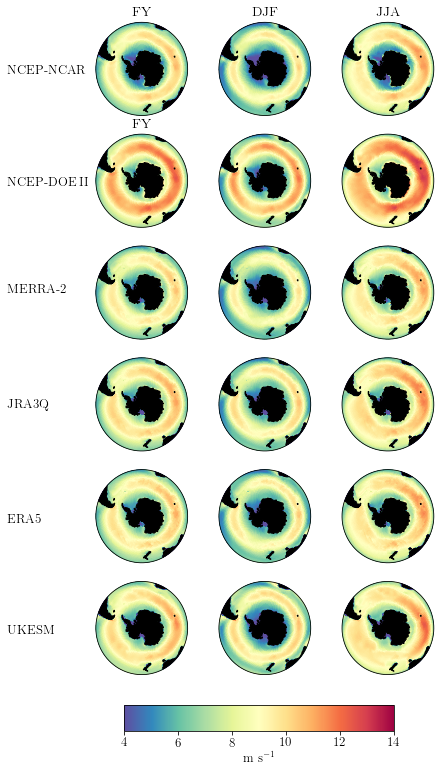

In [24]:
n = ['NCEP-NCAR','NCEP-DOE','MERRA','JRA','ERA5','UKESM',]


seas = ['FY','DJF','JJA']

fact = 0.25
fig = plt.figure(figsize=[25*fact, 48*fact])
tcm = cm.balance


dats = [ncarfy, ncardjf, ncarjja, \
        doefy, doedjf, doejja, \
        merrafy, merradjf, merrajja, \
        JRAfy, JRAdjf, JRAjja,\
        erafy, eradjf, erajja, 
        ukesmfy, ukesmdjf, ukesmjja,\
       ]

botbound = 4
topbound = 14
tint = 0.5
tcm = 'Spectral_r'
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(6, 3, ind, projection=ccrs.Orthographic(0, -90))

        lats = erafy.lat
        lons = erafy.lon
    
        if ind < 18:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 5 :
            tit = f'{tseas}'
        test = dats[ind-1].wspd10m.values
        test = np.squeeze(test)
        bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr)
        ind = ind+1
        
n = ['NCEP-NCAR','NCEP-DOE II','MERRA-2','JRA3Q','ERA5','UKESM',]
wx = np.zeros([6])
wx = np.array([0.82,  0.69, 0.566, 0.434, 0.3, 0.172])
for i in range(0,6):
    #wx[i] = 0.82 - 0.127*i
    fig.text(-0.06,wx[i],f'{n[i]}')

plt.tight_layout()
fig.savefig('./plts/Fig-spat-clim.jpg', dpi = 300, bbox_inches='tight')


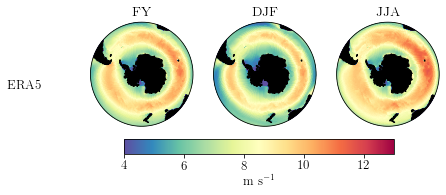

In [66]:
n = ['NCEP-NCAR','NCEP-DOE','MERRA','JRA','ERA5','UKESM',]

n = ['ERA5']

seas = ['FY','DJF','JJA']

fact = 0.25
fig = plt.figure(figsize=[25*fact, 48/6*fact])
tcm = cm.balance


dats = [
        erafy, eradjf, erajja, 
       ]

botbound = 4
topbound = 13
tint = 0.5
tcm = 'Spectral_r'
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(1, 3, ind, projection=ccrs.Orthographic(0, -90))

        lats = erafy.lat
        lons = erafy.lon
    
        if ind < 3:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        test = dats[ind-1].wspd10m.values
        test = np.squeeze(test)
        bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, -0.05, .6, .1])
        ind = ind+1
        
        
#     if tcbr:
        
#         cbar_ax = fig.add_axes([0.2, 0.06, .6, .03]) #left, bottom, width, height
#         fig.colorbar(bc, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
        
n = ['ERA5',]#'NCEP-NCAR','NCEP-DOE II','MERRA-2','JRA3Q','ERA5','UKESM',]
wx = np.zeros([6])
wx = np.array([0.4,  0.69, 0.566, 0.434, 0.3, 0.172])
for i in range(0,1):
    #wx[i] = 0.82 - 0.127*i
    fig.text(-0.06,wx[i],f'{n[i]}')

plt.tight_layout()
fig.savefig('./plts/Fig-spat-clim-ERA.jpg', dpi = 300, bbox_inches='tight')


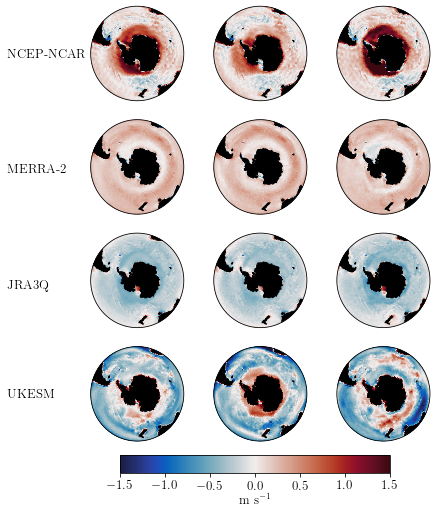

In [53]:
n = ['NCEP-NCAR','MERRA','JRA','UKESM',]

# n = ['ERA5']

seas = ['FY','DJF','JJA']

fact = 0.25
fig = plt.figure(figsize=[25*fact, 48/6*4*fact])
tcm = cm.balance


dats = [ncarfy, ncardjf, ncarjja, \
        merrafy, merradjf, merrajja, \
        JRAfy, JRAdjf, JRAjja,\
        ukesmfy, ukesmdjf, ukesmjja,\
       ]

dats2 = [erafy, eradjf, erajja,\
         erafy, eradjf, erajja, 
         erafy, eradjf, erajja, 
         erafy, eradjf, erajja, 
       ]

botbound = -1.5
topbound = 1.5
tint = 0.5
tcm = cm.balance
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(4, 3, ind, projection=ccrs.Orthographic(0, -90))

        lats = erafy.lat
        lons = erafy.lon
    
        if ind < 12:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        # if ind < 4 :
        #     tit = f'{tseas}'
        test = dats[ind-1].wspd10m.values
        test = np.squeeze(test)
        test2 = dats2[ind-1].wspd10m.values
        test2 = np.squeeze(test2)
        test3 = test2-test
        bc = plot_southern(fig, ax1, lons, lats, test3, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .03])
        ind = ind+1
        
        
#     if tcbr:
        
#         cbar_ax = fig.add_axes([0.2, 0.06, .6, .03]) #left, bottom, width, height
#         fig.colorbar(bc, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
        
n = ['NCEP-NCAR','MERRA-2','JRA3Q','UKESM',]
wx = np.zeros([6])
wx = np.array([0.79,  0.59, 0.39, 0.2])
for i in range(0,4):
    #wx[i] = 0.82 - 0.127*i
    fig.text(-0.05,wx[i],f'{n[i]}')

plt.tight_layout()
fig.savefig('./plts/Fig-spat-clim-other.jpg', dpi = 300, bbox_inches='tight')


## combine these two graphs for the final graph

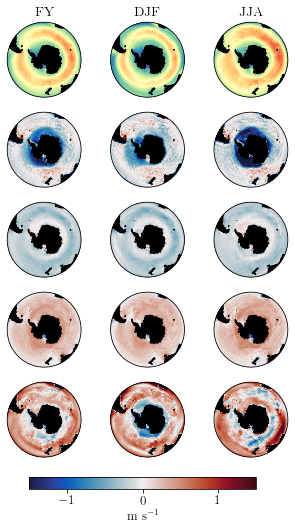

In [70]:
n = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESM',]

# n = ['ERA5']

seas = ['FY','DJF','JJA']

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance


# dats = [ncarfy, ncardjf, ncarjja, \
#         merrafy, merradjf, merrajja, \
#         JRAfy, JRAdjf, JRAjja,\
#         ukesmfy, ukesmdjf, ukesmjja,\
#        ]

# dats2 = [erafy, eradjf, erajja,\
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#        ]


dats = [erafy, eradjf, erajja,\
        ncarfy-erafy, ncardjf-eradjf, ncarjja-erajja, \
        merrafy-erafy, merradjf-eradjf, merrajja-erajja, \
        JRAfy-erafy, JRAdjf-eradjf, JRAjja-erajja,\
        ukesmfy-erafy, ukesmdjf-eradjf, ukesmjja-erajja,\
       ]

# dats2 = [erafy, eradjf, erajja,\
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#        ]

botbound = -1.5
topbound = 1.5
tint = 0.5
tcm = cm.balance
tcm2 = 'Spectral_r'
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        lats = erafy.lat
        lons = erafy.lon
        
        if ind < 4:
            tcm = 'Spectral_r'
            botbound = 4
            topbound = 13
        
        if ind >=4:
            botbound = -1.5
            topbound = 1.5
            tcm = cm.balance
    
        if ind < 15:
            tcbr = False
            
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        test = dats[ind-1].wspd10m.values
        test = np.squeeze(test)
        # test2 = dats2[ind-1].wspd10m.values
        # test2 = np.squeeze(test2)
        # test3 = test2-test
        bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02])
        ind = ind+1
        
        
#     if tcbr:
        
#         cbar_ax = fig.add_axes([0.2, 0.06, .6, .03]) #left, bottom, width, height
#         fig.colorbar(bc, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
        
# n = ['NCEP-NCAR','MERRA-2','JRA3Q','UKESM',]
# wx = np.zeros([6])
# wx = np.array([0.79,  0.59, 0.39, 0.2])
# for i in range(0,4):
#     #wx[i] = 0.82 - 0.127*i
#     fig.text(-0.05,wx[i],f'{n[i]}')

plt.tight_layout()
fig.savefig('./plts/Fig-spat-clim-other.jpg', dpi = 300, bbox_inches='tight')


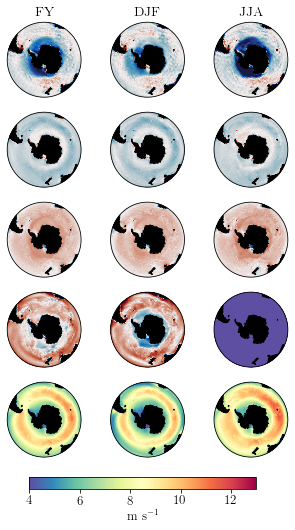

In [79]:
n = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESM',]

# n = ['ERA5']

seas = ['FY','DJF','JJA']

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance


# dats = [ncarfy, ncardjf, ncarjja, \
#         merrafy, merradjf, merrajja, \
#         JRAfy, JRAdjf, JRAjja,\
#         ukesmfy, ukesmdjf, ukesmjja,\
#        ]

# dats2 = [erafy, eradjf, erajja,\
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#        ]


dats = [
        ncarfy-erafy, ncardjf-eradjf, ncarjja-erajja, \
        merrafy-erafy, merradjf-eradjf, merrajja-erajja, \
        JRAfy-erafy, JRAdjf-eradjf, JRAjja-erajja,\
        ukesmfy-erafy, ukesmdjf-eradjf, ukesmjja-erajja,\
        erafy, eradjf, erajja,\
       ]

# dats2 = [erafy, eradjf, erajja,\
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#          erafy, eradjf, erajja, 
#        ]

botbound = -1.5
topbound = 1.5
tint = 0.5
tcm = cm.balance
tcm2 = 'Spectral_r'
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        lats = erafy.lat
        lons = erafy.lon
        
        if ind >=12:
            tcm = 'Spectral_r'
            botbound = 4
            topbound = 13
        
        if ind <12:
            botbound = -1.5
            topbound = 1.5
            tcm = cm.balance
    
        if ind < 15:
            tcbr = False
            
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        test = dats[ind-1].wspd10m.values
        test = np.squeeze(test)
        # test2 = dats2[ind-1].wspd10m.values
        # test2 = np.squeeze(test2)
        # test3 = test2-test
        bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02])
        ind = ind+1
        
        
#     if tcbr:
        
#         cbar_ax = fig.add_axes([0.2, 0.06, .6, .03]) #left, bottom, width, height
#         fig.colorbar(bc, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
        
# n = ['NCEP-NCAR','MERRA-2','JRA3Q','UKESM',]
# wx = np.zeros([6])
# wx = np.array([0.79,  0.59, 0.39, 0.2])
# for i in range(0,4):
#     #wx[i] = 0.82 - 0.127*i
#     fig.text(-0.05,wx[i],f'{n[i]}')

plt.tight_layout()
fig.savefig('./plts/Fig-spat-clim-erabar.jpg', dpi = 300, bbox_inches='tight')


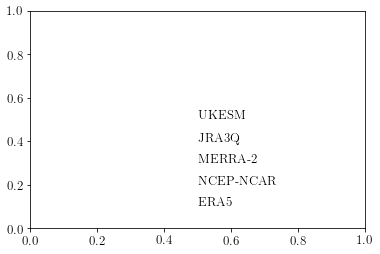

In [80]:
plt.figure()
n = ['ERA5','NCEP-NCAR','MERRA-2','JRA3Q','UKESM',]
wx = np.zeros([6])
wx = np.arange(0.1,1,0.1)
for i in range(0,5):
    #wx[i] = 0.82 - 0.127*i
    plt.text(0.5,wx[i],f'{n[i]}')
    
plt.savefig('./plts/Fig-spat-clim-labels.jpg',dpi = 300, bbox_inches='tight')
    